In [2]:
from qutip import create, destroy, qeye, basis, ket, mesolve, sigmam, sigmap, fidelity, Qobj, tensor, fock_dm, sesolve,fock, sigmax, sigmaz, bell_state, sigmay, qfunc
from qutip.wigner import wigner
from qutip.solver import Options
from scipy.linalg import expm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
sns.set_palette(sns.color_palette('bright'))
#Useful constants 
rabi_0=2e5*np.pi #Hz
omega=2e6 #Hz
ldp=.1/np.sqrt(2)   
epsilon=2*ldp*rabi_0

n=10 #modes of motion
#Relevant Basis States 
g=basis(2,0)
e=basis(2,1)
gg=tensor(g, g, fock(n))   
ge=tensor(g, e, fock(n))
eg=tensor(e, g, fock(n))
ee=tensor(e,e, fock(n))

#Useful ops
sm=tensor(sigmam(),qeye(2))+tensor(qeye(2),sigmam())
sp=tensor(sigmap(),qeye(2))+tensor(qeye(2),sigmap())

$$H_{BSB}= \frac{i \eta}{2} (\Omega_b e^{i \delta_b t}S_{-}a- \Omega^{*}_b e^{-i \delta_b t}S_{+}a^{\dagger})$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega_r e^{i \delta_r t}S_{-}a^{\dagger} - \Omega^{*}_r e^{-i \delta_r t}S_{+}a)$$

In [3]:

def H_MS(rabi_blue, rabi_red, blue_det, red_det):
    #Blue SB Hamiltonian terms
    H_BSB_i=(1j*ldp*rabi_blue/2)*tensor(sm,destroy(n))
    def H_BSB_TD_i(t, args):
        return np.exp(1j*(blue_det)*t)                 

    H_BSB_ii=(-1j*ldp*rabi_blue/2)*tensor(sp,create(n))
    def H_BSB_TD_ii(t, args):
        return np.exp(-1j*(blue_det)*t)

    #Red SB Hamiltonian terms
    H_RSB_i=(1j*ldp*rabi_red/2)*tensor(sm,create(n))
    def H_RSB_TD_i(t, args):
        return np.exp(1j*(red_det)*t)                 

    H_RSB_ii=(-1j*ldp*rabi_red/2)*tensor(sp,destroy(n))
    def H_RSB_TD_ii(t, args):
        return np.exp(-1j*(red_det)*t)

    #  Blue H---------------------------------------| Red H----------------------------------------|
    H=[[H_BSB_i, H_BSB_TD_i], [H_BSB_ii, H_BSB_TD_ii],[H_RSB_i, H_RSB_TD_i], [H_RSB_ii, H_RSB_TD_ii]]
    return H

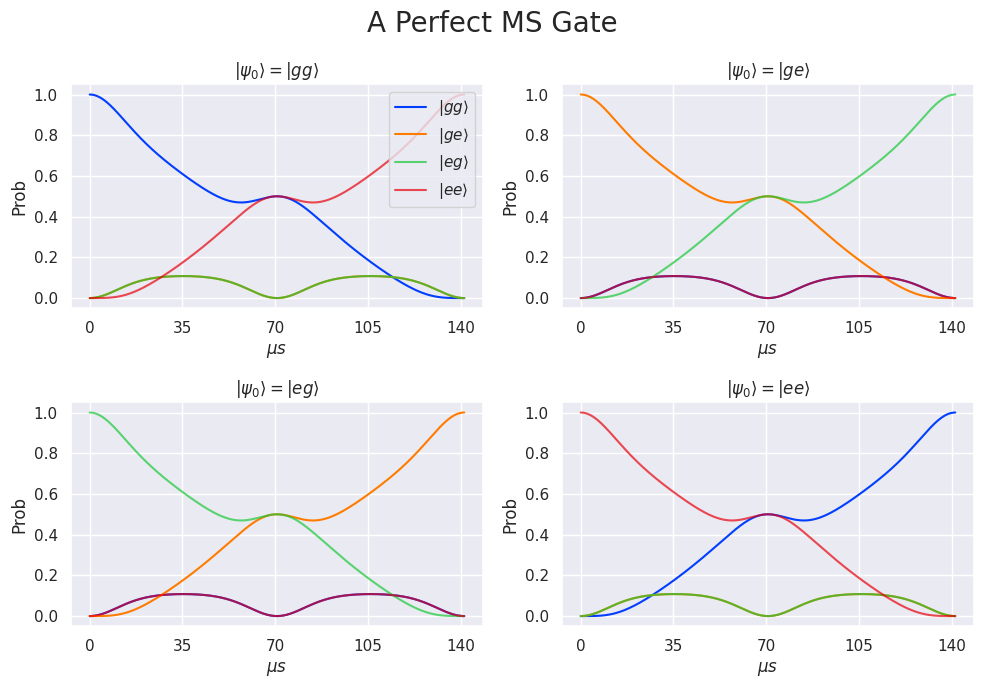

In [5]:
gate_time=4*np.pi/epsilon
tlist=np.linspace(0, gate_time, 1000)

z_basis=[tensor(g,g,qeye(n))*tensor(g.dag(),g.dag(), qeye(n)), tensor(g,e,qeye(n))*tensor(g.dag(),e.dag(), qeye(n)), 
        tensor(e,g,qeye(n))*tensor(e.dag(),g.dag(), qeye(n)), tensor(e,e,qeye(n))*tensor(e.dag(),e.dag(), qeye(n))]
H=H_MS(rabi_0, rabi_0, epsilon, -epsilon)

def plot_evol(H, psi0, title, labels=False, expect=z_basis):
    evol=mesolve(H, psi0, tlist, e_ops=expect)
    plt.plot(tlist, evol.expect[0], label=r'$|gg\rangle$')
    plt.plot(tlist, evol.expect[1], label=r'$|ge\rangle$')
    plt.plot(tlist, evol.expect[2], label=r'$|eg\rangle$', alpha=.7)
    plt.plot(tlist, evol.expect[3], label=r'$|ee\rangle$', alpha=.7)
    plt.xticks(np.arange(0, 1.60e-4, .35e-4), labels=[f'{x}' for x in np.arange(0,160,35)])
    plt.xlabel(r'$\mu s$')
    plt.title(r"$|\psi_0\rangle=$"+title)
    plt.ylabel('Prob')
    if labels: plt.legend(loc='upper right')
def plot_evol_basis(H, suptitle):
    psi0=[gg,ge,eg,ee]
    plt.figure(figsize=(10,7))
    labels=[True, False, False, False]
    for rho0,labels, title,i in zip(psi0, labels, [r'$|gg\rangle$',r'$|ge\rangle$',r'$|eg\rangle$',r'$|ee\rangle$'], list(range(1,5))):
        plt.subplot(2,2, i)
        plot_evol(H,rho0, title, labels)
    plt.suptitle(suptitle, fontsize=20)
    plt.tight_layout()
    plt.show()
plot_evol_basis(H,'A Perfect MS Gate')


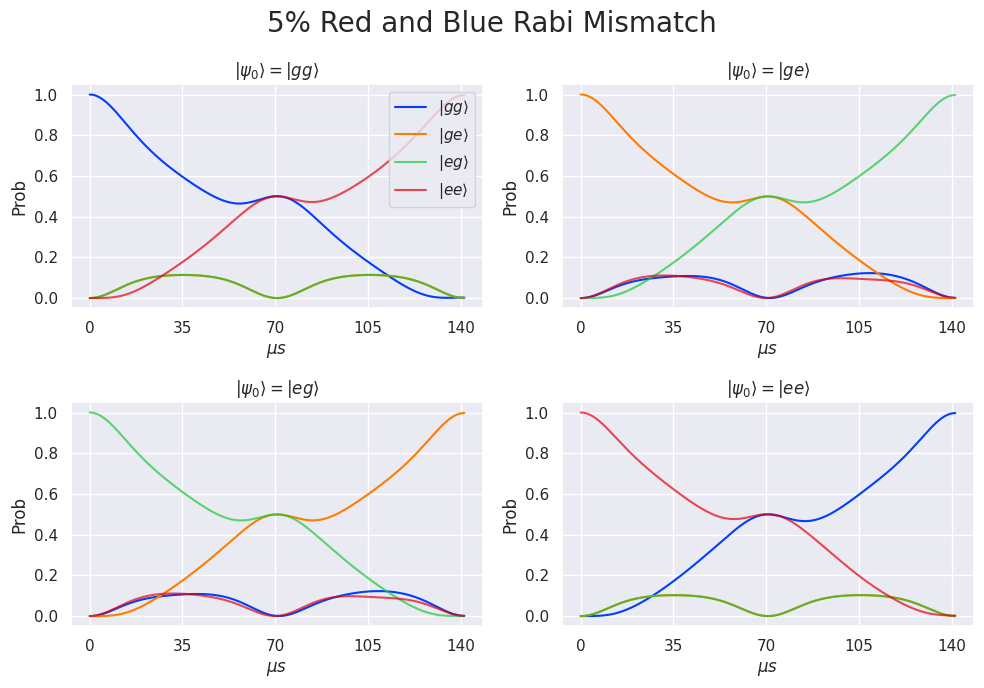

In [5]:


H_rabi=H_MS(rabi_0*.975, rabi_0*1.025    , epsilon, -epsilon)
plot_evol_basis(H_rabi, '5% Red and Blue Rabi Mismatch')

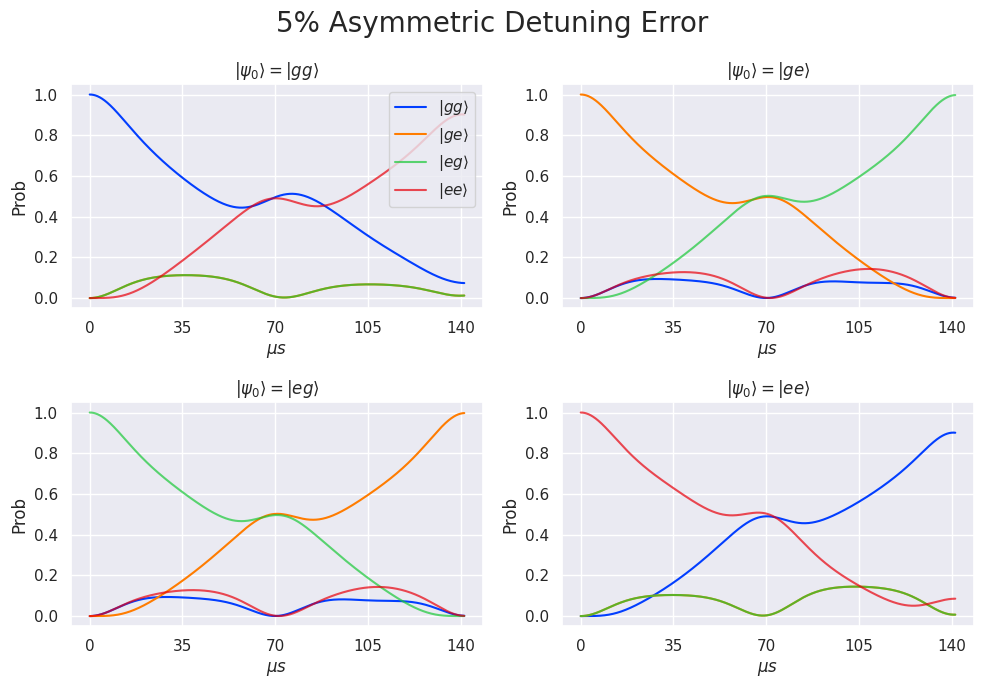

In [6]:
H_asym=H_MS(rabi_0, rabi_0, epsilon*1.05, -epsilon*.95)
plot_evol_basis(H_asym, "5% Asymmetric Detuning Error")

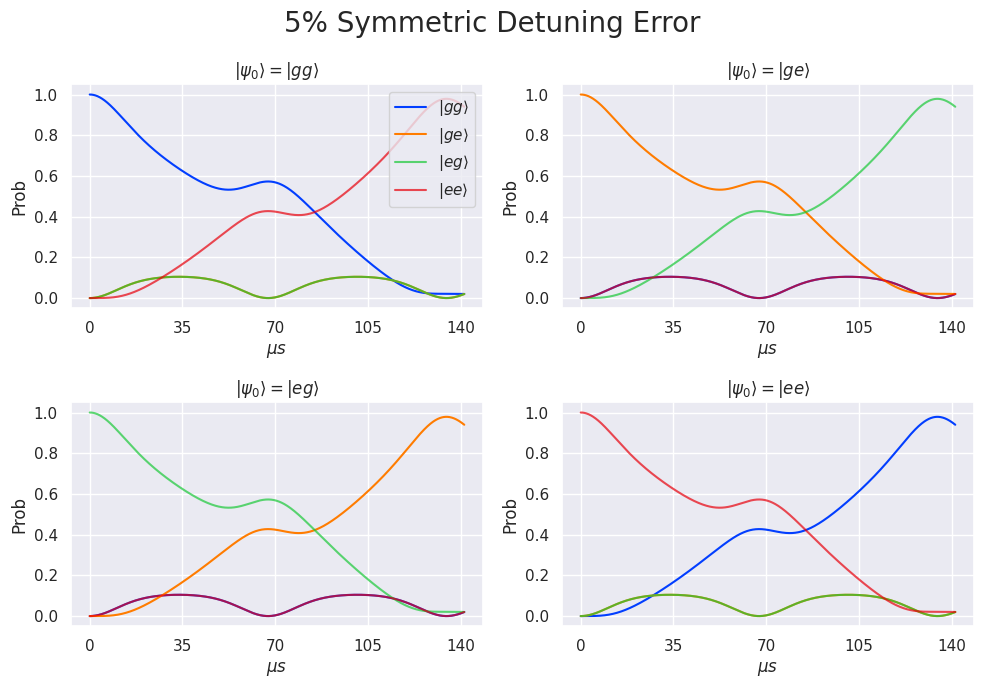

In [7]:
H_sym=H_MS(rabi_0, rabi_0, epsilon*1.05, -epsilon*1.05)
plot_evol_basis(H_sym, "5% Symmetric Detuning Error")

# Analysis
The MS gate appears to be more robust to slight drifts in the Rabi freq (proportional to laser amplitude) than other error sources discussed in this work. But, the drift in trap frequency (symmetric error) appears to be the most destructive to gate fidelity. The MS gate is crucial to generating maximally entangled states, and the trap frequency drift is far less robust in this regard than laser frequency or amplitude errors based on the data in this work. Regarding generating maximally entangled states, the MS gate is suprisingly very robust to minor drifts in laser amplitude and frequency, though the laser frequency drifts are slightly less robust than laser amplitude drifts. <br>
Refer to the red and blue sideband hamiltonians, assume $\Omega_r=\Omega_b=\Omega$:
$$H_{BSB}= \frac{i \eta}{2} (\Omega e^{i (-\nu+\delta) t}S_{-}a- \Omega^{*} e^{-i (-\nu+\delta) t}S_{+}a^{\dagger}),$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega e^{i (\nu+\delta) t}S_{-}a^{\dagger} - \Omega^{*} e^{-i (\nu+\delta) t}S_{+}a),$$
with motional mode frequency $\nu$, laser detuning frequency $\delta$ for both ions. consider $\epsilon\equiv \nu + \delta$ and $-\epsilon\equiv -\nu+\delta$ ($-\delta_r=\delta_b\equiv \delta$) so that 
$$H_{BSB}= \frac{i \eta}{2} (\Omega e^{i \epsilon t}S_{-}a- \Omega^{*} e^{-i \epsilon t}S_{+}a^{\dagger}),$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega e^{i \epsilon t}S_{-}a^{\dagger} - \Omega^{*} e^{-i \epsilon t}S_{+}a).$$
Now consider a slight frequency offset, $\Delta$, such that 
$$-\epsilon-\Delta=-(\nu+\Delta)+\delta, \epsilon+\Delta=(\nu+\Delta)+\delta;$$
the trap frequency error thus produces a symmetric error. 
$$-\epsilon-\Delta=-\nu+(\delta+\Delta), \epsilon-\Delta=\nu+(\delta+\Delta);$$
the laser detuning error produces an asymmetric error. However, the AC Stark shift (drift in qubit transition frequency due to coupling to off-resonant driving from the lasers) can also produce an asymmetric error. Consider $\omega_1$ is a laser frequency that is off-resonant from a virtual intermediate state $\ket{v}  by $\pm\mu$, the laser detuning is thus $\delta=\omega_1-\omega_{eg}$  ([Molmer, Sorenson](https://arxiv.org/abs/quant-ph/0002024)); recall that $-\delta_r=\delta_b\equiv \delta$, $\delta_r$ ($\omega_1=\omega_{eg}-\mu$) and $\delta_b$ ($\omega_1=\omega_{eg}+\mu$) will have equal magnitudes with opposite signs. We now have 
$$-\epsilon+\Delta=-\nu+(\omega_1-(\omega_{eg}+\Delta)), \epsilon+\Delta=\nu+(\omega_1-(\omega_{eg}+\Delta));$$
The AC Stark shift produces an asymmetric error.

# Analysis

The MS gate appears to be more robust to slight drifts in the Rabi freq (proportional to laser amplitude) than other error sources discussed in this work. But, the drift in trap frequency (symmetric error) appears to be the most destructive to gate fidelity. The MS gate is crucial to generating maximally entangled states, and the trap frequency drift is far less robust in this regard than laser frequency or amplitude errors based on the data in this work. Regarding generating maximally entangled states, the MS gate is suprisingly very robust to minor drifts in laser amplitude and frequency, though the laser frequency drifts are slightly less robust than laser amplitude drifts. <br>

Refer to the red and blue sideband hamiltonians, assume $\Omega_r=\Omega_b=\Omega$:

$$H_{BSB}= \frac{i \eta}{2} (\Omega e^{i (-\nu+\delta) t}S_{-}a- \Omega^{*} e^{-i (-\nu+\delta) t}S_{+}a^{\dagger}),$$

$$H_{RSB}= \frac{i \eta}{2} (\Omega e^{i (\nu+\delta) t}S_{-}a^{\dagger} - \Omega^{*} e^{-i (\nu+\delta) t}S_{+}a),$$

with motional mode frequency $\nu$, laser detuning frequency $\delta$ for both ions. consider $\epsilon\equiv \nu + \delta$ and $-\epsilon\equiv -\nu+\delta$ ($-\delta_r=\delta_b\equiv \delta$) so that

$$H_{BSB}= \frac{i \eta}{2} (\Omega e^{i \epsilon t}S_{-}a- \Omega^{*} e^{-i \epsilon t}S_{+}a^{\dagger}),$$

$$H_{RSB}= \frac{i \eta}{2} (\Omega e^{i \epsilon t}S_{-}a^{\dagger} - \Omega^{*} e^{-i \epsilon t}S_{+}a).$$

Now consider a slight frequency offset, $\Delta$, such that

$$-\epsilon-\Delta=-(\nu+\Delta)+\delta, \epsilon+\Delta=(\nu+\Delta)+\delta;$$

the trap frequency error thus produces a symmetric error.

$$-\epsilon-\Delta=-\nu+(\delta+\Delta), \epsilon-\Delta=\nu+(\delta+\Delta);$$

the laser detuning error produces an asymmetric error. However, the AC Stark shift (drift in qubit transition frequency due to coupling to off-resonant driving from the lasers) can also produce an asymmetric error. Consider $\omega_1$ (carrier), $\omega_2$, $\omega_3$ are laser frequencies that will drive our Raman transitions that are detuned by $\delta$. $\delta_r=\omega_1-\omega_2-\omega_{01}$, $\delta_b=\omega_3-\omega_1-\omega_{01}$; $\omega_{01}$ is the qubit frequency. Recall that $-\delta_r=\delta_b\equiv \delta$, $\delta_r$ and $\delta_b$ will have equal magnitudes with opposite signs. With a drift, $\Delta$, to qubit frequency now have

$$-\epsilon+\Delta=-\nu+(\omega_3-\omega_1-(\omega_{01}+\Delta)), \epsilon+\Delta=\nu+(\delta_r=\omega_1-\omega_2-(\omega_{01}+\Delta));$$

the AC Stark shift produces an asymmetric error.

  
# The Sidequest: Find Why $\eta$ Has $\frac{1}{\sqrt{2}}$ Factor With a Two Ion Chain

This sidequest is based on Yukai Wu's 2019 doctoral dissertation.

  

Consider a quartic confining pseudopotential derived from alternating oscillating radio-frequency electric fields in a vacuum. Around the center of the trap, ignoring the transverse motion (save that for later), we get

$$U=\sum_i(-\frac{1}{2}\alpha_{2} z^{2}_{i} +\frac{1}{4}\alpha_{4} z^4_i)+\sum_{i<j}\frac{1}{4\pi\epsilon_0}\frac{e^2}{\left|

z_i-z_j\right|}, \ \ (\alpha_2, \alpha_4 >0).$$

Define a length unit $l_0\equiv(\frac{e^2}{4\pi\epsilon_0\alpha_2})^{1/3}$, a dimensionless coordinate $u_i\equiv\frac{z_i}{l_0}$, and a dimensionless potential energy $V \equiv \frac{4 \pi \epsilon_0 l_0 }{e^2}U$. Now, we get

$$V=\sum_i \left(\frac{1}{2}u^2_i+\frac{1}{4}\gamma_4 u^4_i\right)+\frac{1}{2}\sum_{i\neq j}\frac{1}{\left|u_i-u_j\right|},$$

where $\gamma_4\equiv\alpha_4l_0 \alpha_2$ is a dimensionless constant that determines the shape of the equilibrium configuration. We can solve for the equilibrium positions by minimizing $V$ using Newton's method and the Hessian $\textbf{H}_V$:

$$\frac{\partial V}{\partial u_m}=-u_m+\gamma_4 u^3_m-\sum_{j\neq m}\frac{u_m-u_j}{\left|u_m-u_j \right|^3},$$

$$\frac{\partial^2 V}{\partial u^2_m}=-1+3\gamma_4 u^2_m+\sum_{j\neq m}\frac{2}{\left|u_m -u_j\right|^3},$$

$$\frac{\partial V}{\partial u_m \partial u_n}=-\frac{2}{\left|u_m-u_n\right|^3} \ (m\neq n).$$

Now that we have our equilibrium positions $u^{(0)}_i$ along the axial $z$ direction, we can expand $U$ to consider the transverse potential

$$U=\sum_i \left(-\frac{1}{2}\alpha_2 z^2_i +\frac{1}{4}\alpha_4 z^4_i+\frac{1}{2}\omega^2_x x^2_i+\frac{1}{2}\omega^2_y y^2_i\right)+\frac{e^2}{4\pi\epsilon_0}\sum_{i<j}\frac{1}{\left|\vec{r}_i-\vec{r}_j\right|}.$$

Where $\omega_x$ and $\omega_y$ are the $x$ and $y$ components of the trapping frequency of the pseudopotential. Near equilibrium, $y^{(0)}_i=x^{(0)}_i=0, z^{(0)}_i=l_0u^{(0)}_i$, we can see how $U$ behaves near equilibrium by a second-order Taylor series

$$U=U_0+\left.\frac{1}{2}\sum_{i,j,\alpha,\beta}\frac{\partial^2 U}{\partial r_{i,\alpha}\partial r_{j,\beta}}\right|_{eq.}(r_{i,\alpha}-r^{(0)}_{i,\alpha})(r_{i,\beta}-r^{(0)}_{j,\beta})+...$$

where $\alpha,\beta$ are the Cartesian coordinates (components of $\vec{r_i},\vec{r_j}$) for ions $i,j$.

We can separate $U$ into $x$, $y$, and $z$ components, and are interested in small movements around the equilibrium configuration. So, we can separate the transverse motion, $x$, near equilibrium positions, we have

$$\frac{\partial^2 U}{\partial x^2_m}=m\omega^2_x-\frac{e^2}{4\pi \epsilon_0}\sum_{j\neq m}\frac{1}{z^3_{mj}},$$

$$\frac{\partial^2 U}{\partial x_m \partial x_n}=\frac{e^2}{4\pi\epsilon_0}\frac{1}{z^3_{mn}} (m\neq n),$$

where $z_{ij}=\left|z^{(0)}_i-z^{(0)}_j\right|$ for ions $i,j \ (i\neq j).$

We can diagonalize $\frac{\partial^2 U}{\partial x_m \partial x_n}$ to get the normalized mode eigenvectors. Quantized, these modes yield the phonon Hamiltonian. In the case of our two ion system, we get

$$\frac{e^2}{4\pi\epsilon_0}\frac{1}{z_{ij}^3}\left(\frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ -1 & 1\end{bmatrix}^{-1}\begin{bmatrix} 1 & 0 \\ 0 & -1\end{bmatrix}\begin{bmatrix} 1 & 1 \\ -1 & 1\end{bmatrix}\right),$$

$z_{ij}$ was simplified since $\left|z^{(0)}_i-z^{0}_j\right|=\left|z^{(0)}_j-z^{0}_i\right|\equiv z_{ij}$. We now have our normalized mode vectors $b^k_j$ for $k$ mode vectors and ion $j$. In the 2 ion system, these 2 normal mode vectors are the tilt mode, $b^0_j=\frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ -1\end{bmatrix}$, and the COM mode, $b^1_j=\frac{-1}{\sqrt{2}}\begin{bmatrix}1 \\ 1\end{bmatrix}$. 

Consider the interaction Hamiltonian between an ion's spin, the light field, and the transverse motion (assume that Rabi frequencies from all lasers in the system are similar):
$$H^{eff}_I=\hbar\Omega_j\cos\left(\delta t -\Delta\vec{k}x_j(t)\right)\left(\hat{\sigma}_{x,j}\cos\left(\phi^s_j\right)-\hat{\sigma}_{y,j}\sin\left(\phi^s_j\right)\right),$$
where $\Delta \vec{k}$ is the wavevector of the lasers acting on ion $j$, $\phi^m_j\equiv\frac{\Delta\phi_b-\Delta\phi_r}{2},\phi^s_j\equiv\frac{\Delta\phi_b+\Delta\phi_r}{2}$ are the motion and spin phases from the red and blue sideband optical phase differences $\Delta\phi_r=\omega_1-\omega_2$, $\Delta\phi_b=\omega_3-\omega_1$. 
$x_j(t)$ describes the quantized transverse motion (recall that the small oscillating motion in the ion chain are separable by direction; the quantized motion of $y$, $z$ are solvable in a similar manner):
$$x_j(t)=\sum_kb_j^k\sqrt{\frac{\hbar}{2m\omega_k}}\left(a_ke^{-i\omega_k t}+a^{\dagger}_ke^{i\omega_kt}\right) $$

Define the Lamb-Dicke parameter $\eta_k= \Delta\vec{k}\sqrt{\frac{\hbar}{2m\omega_k}}$, which determines the coupling strength between the lasers and the motional mode.  $\hat{\sigma_j^n}\equiv\left(\hat{\sigma}_{x,j}\cos\left(\phi^s_j\right)-\hat{\sigma}_{y,j}\sin\left(\phi^s_j\right)\right)$ for simplification. Now, consider the interacting Hamiltonian:

$$H_I=\hbar\Omega_j \cos\left(\delta t+\phi^m_j-\sum_k \eta_kb^k_j\left(a_ke^{-i\omega_k t}+a^{\dagger}_ke^{i\omega_kt}\right)\right)\hat{\sigma}_j^n.$$

We can see clearly that for each mode $k$, $\eta_k$ is scaled by some amount $\pm\frac{1}{\sqrt{2}}$ from both components of ion $j$'s normalized mode eigenvectors. 

# Other Sidequest: Simulating Errors
$$\ket{\phi}=\frac{1}{\sqrt{2}}(\ket{gg}-i\ket{ee}), \ket{\psi}=U_{MS}(\frac{\pi}{4})\ket{gg}$$
$U_{MS}(t)$ is derived from the Magnus expansion of $H_{MS}=H_{BSB}+H_{RSB}$ from earlier. $\ket{\phi}$ is the maximally-entangled state $\ket{\psi}$ when $U_{MS}$ is free of error; $\ket{\phi}=\exp\left(\frac{-i\pi}{4}X\otimes X\right)\ket{gg}$. 
$$\mathcal{F}(\rho, \sigma)\equiv \textrm{Tr}\left(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}}\right)^2,$$
$$\rho= \ket{\psi}\bra{\psi}, \sigma=\ket{\phi}\bra{\phi}$$
The fidelity of density matrices $\rho$ and $\sigma$ will serve as a quality quantum distance metric to help us determine the impact of various errors on the MS gate's fidelity.

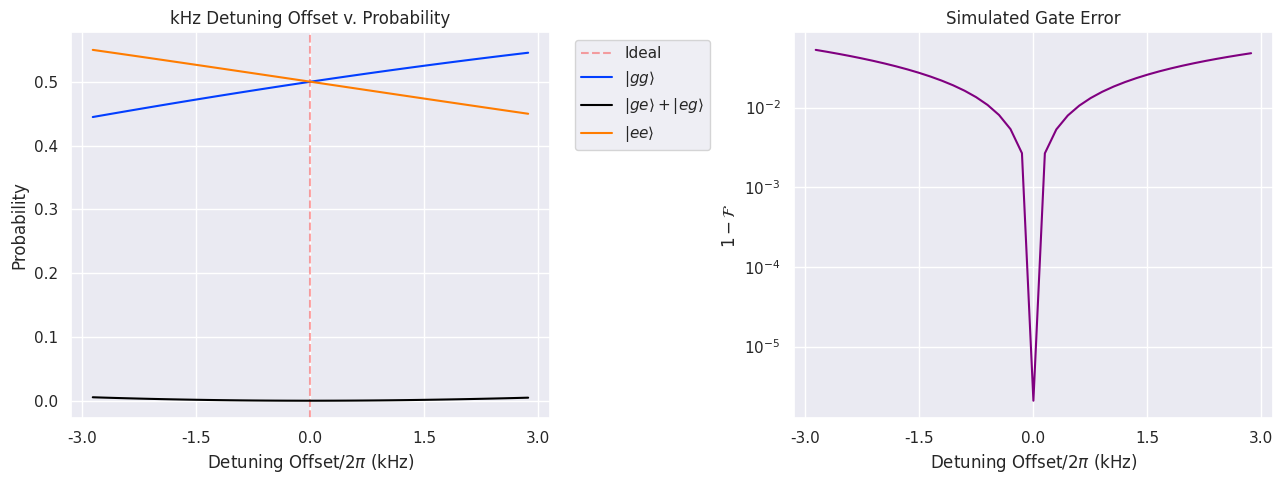

In [7]:
num_int=40 #n-1
gate_time=np.linspace(0,2*np.pi/epsilon,num_int) # 1 gate time
detuning_offset=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None)
res_list=np.empty((3,num_int-1))
for i in range(num_int-1):
    H=H_MS(rabi_0,rabi_0, epsilon+detuning_offset[i], -epsilon-detuning_offset[i])
    res=mesolve(H,gg, gate_time, e_ops=z_basis)
    res_list[0][i]=res.expect[0][-1]
    res_list[1][i]=res.expect[1][-1]+res.expect[2][-1]
    res_list[2][i]=res.expect[3][-1]
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.axvline(label='Ideal', color='red', ls='--', alpha=.35)
plt.plot(detuning_offset,res_list[0], label=r'$|gg\rangle$')
plt.plot(detuning_offset, res_list[1], color='black', label=r'$|ge\rangle + |eg\rangle$')
plt.plot(detuning_offset,res_list[2], label=r'$|ee\rangle$')
plt.xlabel(r'Detuning Offset/$2\pi$ (kHz)')
plt.xticks(np.linspace(-3000, 3000, 5), labels=[f'{x}' for x in np.linspace(-3, 3, 5)])
plt.ylabel('Probability')
plt.title('kHz Detuning Offset v. Probability')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))

plt.subplot(1,2,2)
res_list=np.empty(num_int-1)
max_ent=(1/np.sqrt(2))*(gg-1j*ee)
for i in range(num_int-1):
    H=H_MS(rabi_0,rabi_0, epsilon+detuning_offset[i], -epsilon-detuning_offset[i])
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    res_list[i]=fidelity(res*res.dag(), max_ent*max_ent.dag())
plt.plot(detuning_offset,res_list, color='purple')
plt.yscale('log')
plt.xlabel(r'Detuning Offset/$2\pi$ (kHz)')
plt.xticks(np.linspace(-3000, 3000, 5), labels=[f'{x}' for x in np.linspace(-3, 3, 5)])
plt.ylabel(r'$1-\mathcal{F}$')
plt.title('Simulated Gate Error')
plt.tight_layout()
plt.show()

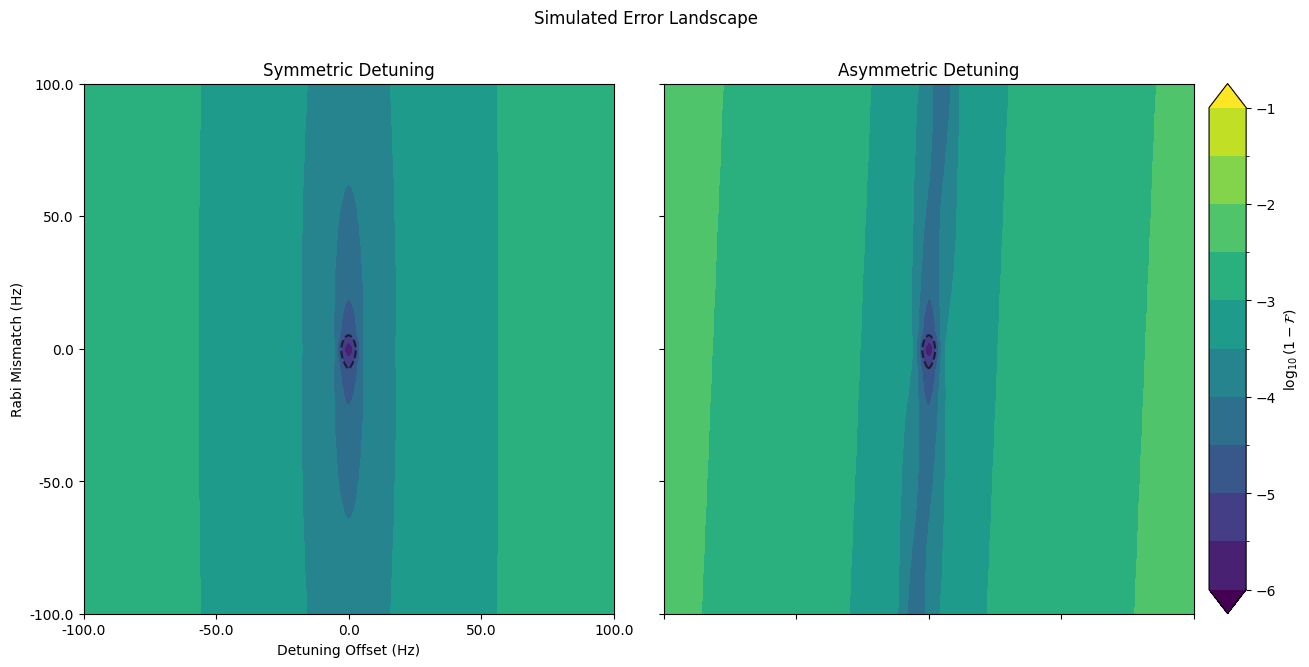

In [20]:
from scipy.interpolate import RegularGridInterpolator
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib
matplotlib.rc_file_defaults()
detuning_offset=np.concatenate((np.linspace(-100, 0, int(num_int/2)),
                                np.linspace(0, 100, int(num_int/2))[1:]), None).reshape(1, num_int-1)
rabi_det=np.concatenate((np.linspace(-100, 0, int(num_int/2)),
                                np.linspace(0, 100, int(num_int/2))[1:]), None).reshape(num_int-1,1)
precision=35
num_int=40
fig=plt.figure(figsize=(15,7),)
ax = ImageGrid(fig, 111,          
                nrows_ncols=(1,2),
                axes_pad=.5,
                share_all=False,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="7%",
                cbar_pad=0.15,
                )
method='cubic'
bounds=np.arange(-6,-.5, 1/2)
norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
x=np.linspace(0,num_int-1,num_int-1)
y=np.linspace(0,num_int-1,num_int-1)
xt, yt = np.meshgrid(np.linspace(0, num_int-1, (num_int-1)*precision), np.linspace(0, num_int-1, (num_int-1)*precision), indexing='ij')
interp=np.array([xt.ravel(), yt.ravel()]).T
X,Y=np.meshgrid(x,y, indexing='ij')
max_ent=(1/np.sqrt(2))*(gg-1j*ee)
def t_evol(rabi_det, detuning_offset):
    H=H_MS(rabi_0+rabi_det,rabi_0-rabi_det, epsilon+detuning_offset, -epsilon-detuning_offset)
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    return np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))
vf=np.vectorize(t_evol)
res_list_sym=vf(rabi_det, detuning_offset)
f=RegularGridInterpolator([x,y], res_list_sym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=ax[0].pcolormesh(heatmap,cmap='viridis',norm=norm)
ax[0].set_xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-100, 100, 5)])
ax[0].set_yticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-100, 100, 5)])
ax[0].contour(heatmap, levels=[-10e6,-5], colors='black', linestyles='dashed', alpha=.6)
ax[0].set_ylabel('Rabi Mismatch (Hz)')
ax[0].set_xlabel('Detuning Offset (Hz)')
ax[0].set_title('Symmetric Detuning')
ax[0].set_aspect('auto')
#plt.colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$',)
#plt.ylabel(r'$1-\mathcal{F}$')
def t_evol(rabi_det, detuning_offset):
    H=H_MS(rabi_0+rabi_det,rabi_0-rabi_det, epsilon+detuning_offset, -epsilon+detuning_offset)
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    return np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))
vf=np.vectorize(t_evol)
res_list_asym=vf(rabi_det, detuning_offset)
f=RegularGridInterpolator([x,y], res_list_asym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=ax[1].pcolormesh(heatmap,cmap='viridis', norm=norm,)
ax[1].contour(heatmap, levels=[-10e6,-5], colors='black', linestyles='dashed', alpha=.6)
ax[1].set_xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[None for x in np.linspace(-100, 100, 5)])
ax[1].set_yticks(np.linspace(0, (num_int-1)*precision, 5),)
ax[1].set_aspect('auto')
ax[1].set_title('Asymmetric Detuning')
ax.cbar_axes[0].colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$')
#plt.ylabel(r'$1-\mathcal{F}$')
plt.suptitle('Simulated Error Landscape')
plt.show()

Dashed contour lines where $1-\mathcal{F}<10^{-5}$

It appears as though the asymmetric detuning has a moment where its fidelity is good even in the prescence of Rabi mismatches...almost as if it can be calibrated.

# When Rabi Frequency Offsets are Similar

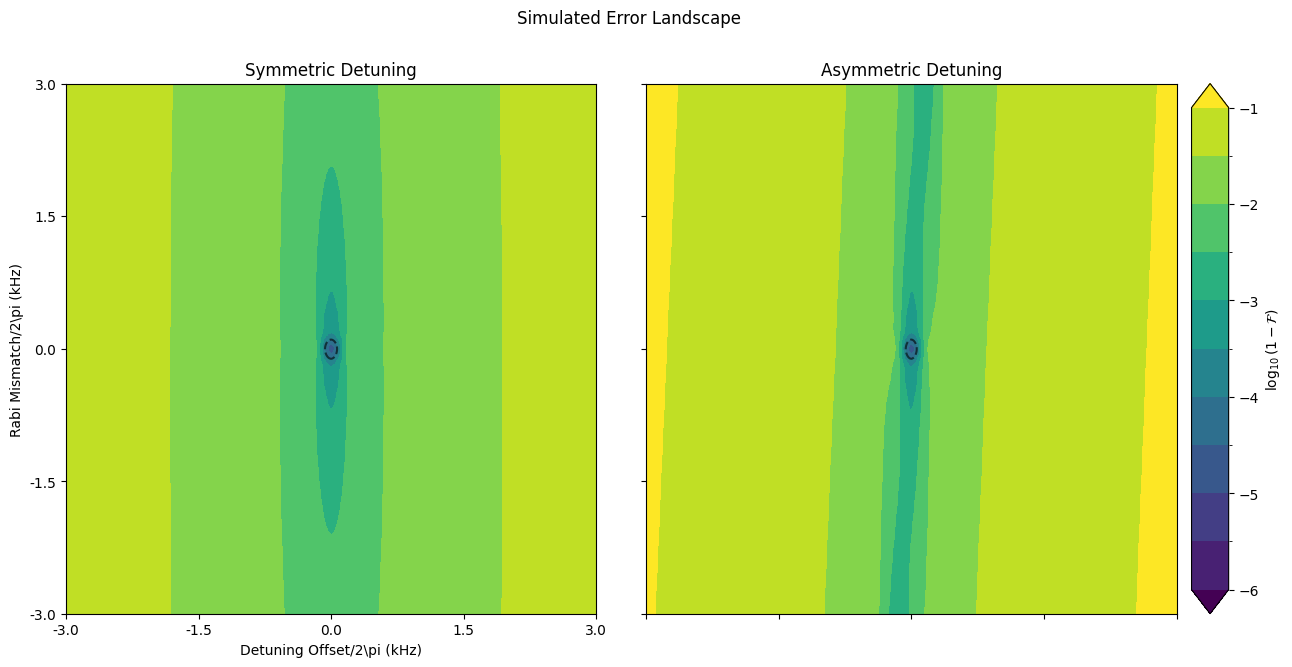

In [8]:
precision=35
num_int=40
detuning_offset=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),
                                np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None).reshape(1, num_int-1)
rabi_det=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),
                         np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None).reshape(num_int-1,1)
fig=plt.figure(figsize=(15,7),)
ax = ImageGrid(fig, 111,          
                nrows_ncols=(1,2),
                axes_pad=.5,
                share_all=False,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="7%",
                cbar_pad=0.15,
                )
method='cubic'
bounds=np.arange(-6,-.5, 1/2)
norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
x=np.linspace(0,num_int-1,num_int-1)
y=np.linspace(0,num_int-1,num_int-1)
xt, yt = np.meshgrid(np.linspace(0, num_int-1, (num_int-1)*precision), np.linspace(0, num_int-1, (num_int-1)*precision), indexing='ij')
interp=np.array([xt.ravel(), yt.ravel()]).T
X,Y=np.meshgrid(x,y, indexing='ij')
max_ent=(1/np.sqrt(2))*(gg-1j*ee)
def t_evol(rabi_det, detuning_offset):
    H=H_MS(rabi_0+rabi_det,rabi_0+rabi_det, epsilon+detuning_offset, -epsilon-detuning_offset)
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    return np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))
vf=np.vectorize(t_evol)
res_list_sym=vf(rabi_det, detuning_offset)
f=RegularGridInterpolator([x,y], res_list_sym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=ax[0].pcolormesh(heatmap,cmap='viridis',norm=norm)
ax[0].set_xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-3, 3, 5)])
ax[0].set_yticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-3, 3, 5)])
ax[0].contour(heatmap, levels=[-10e6,-4], colors='black', linestyles='dashed', alpha=.6)
ax[0].set_ylabel(r'Rabi Mismatch/$2\pi$ (kHz)')
ax[0].set_xlabel(r'Detuning Offset/$2\pi$ (kHz)')
ax[0].set_title('Symmetric Detuning')
ax[0].set_aspect('auto')
#plt.colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$',)
#plt.ylabel(r'$1-\mathcal{F}$')
def t_evol(rabi_det, detuning_offset):
    H=H_MS(rabi_0+rabi_det,rabi_0+rabi_det, epsilon+detuning_offset, -epsilon+detuning_offset)
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    return np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))
vf=np.vectorize(t_evol)
res_list_asym=vf(rabi_det, detuning_offset)
f=RegularGridInterpolator([x,y], res_list_asym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=ax[1].pcolormesh(heatmap,cmap='viridis', norm=norm,)
ax[1].contour(heatmap, levels=[-10e6,-4], colors='black', linestyles='dashed', alpha=.6)
ax[1].set_xticks(np.linspace(0, (num_int-1)*precision, 5),labels=[None for x in np.empty((5,1))])
ax[1].set_yticks(np.linspace(0, (num_int-1)*precision, 5),)
ax[1].set_aspect('auto')
ax[1].set_title('Asymmetric Detuning')
ax.cbar_axes[0].colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$')
#plt.ylabel(r'$1-\mathcal{F}$')
plt.suptitle('Simulated Error Landscape')
plt.show()

Dashed contour lines where $1-\mathcal{F}<10^{-4}$.

Even with more extreme Rabi mismatches, we can still calibrate the MS gate to get over 3 9's of fidelity!

# Further Progressions on This Topic
- Simulate calibration of MS gate with frequency modulation for robust gates.
- Simulate MS gates with larger ion chains.
- Simulate gate error models with other major error sources, such as heating errors and crosstalk between motional modes.
- Efficiently simulate the MS (with tensor networks?)

# Miscellaneous: Wigner Function Animation

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.interpolate import RegularGridInterpolator
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib
matplotlib.rc_file_defaults()
H=H_MS(rabi_0,rabi_0, -epsilon, epsilon)
gate_time=np.linspace(0,2*np.pi/epsilon,400)
psi=mesolve(H,gg, gate_time).states
xvec=np.linspace(-5,5,500)
W_fin=wigner(psi[-1], xvec,xvec)
norm=colors.Normalize(-W_fin.max(),W_fin.max())
fig,ax=plt.subplots()
c=ax.contourf(xvec,xvec,W_fin, norm=norm, cmap='RdBu')
def anim(i):
    plt.cla()
    W=wigner(psi[i],xvec,xvec)
    p=ax.contourf(xvec,xvec,W, 100, cmap='RdBu', norm=norm)
    ax.set_ylabel('p')
    ax.set_xlabel('x')
    ax.text(-4.9,4.5,f'Gate Time: {(i)/(gate_time.__len__()-1):.3}')
    return ax
fig.colorbar(c)
#fig.suptitle()
ani=FuncAnimation(fig=fig,func=anim, frames=gate_time.__len__(),interval=25)
ani.save('wigner.mp4', )

In [1]:
%%HTML
<video controls>
  <source src="wigner.mp4" type="video/mp4">
</video>